In [2]:
# %load Himmelblau-Function-SA.py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit as tt

# Continuous Simulated Annealing

In [19]:
parameters_continuous = {
                          'perturbation_parameter' : 0.1
                        , 'initial_temperature' : 1000
                        , 'cooling_iterations' : 300
                        , 'cooling_parameter' : 0.85
                        , 'neighbourhood_searches' : 15
                        , 'initial_inputs' : np.array([[2,1]])
                        , 'num_inputs' : 2
                          }

In [41]:
def himmelblau(inputs):
    
    # the objective function
    
    x = inputs[0,0]
    y = inputs[0,1]
    
    return ((x**2)+y-11)**2+(x+(y**2)-7)**2

In [4]:
def peturb_inputs_continuous(parameters, inputs):
    
    # unpack parameters
    perturbation_parameter = parameters['perturbation_parameter']
    num_inputs = parameters['num_inputs']
    
    # function to set numbers to -1 if r<0.5 and 1 otherwise
    def peturb_function_1(x):
        return -1 if x < 0.5 else 1
    peturb_vfunction_1 = np.vectorize(peturb_function_1)
    
    # array of signs for perturbation direction
    sign_array = peturb_vfunction_1(np.random.uniform(0,1,(1,num_inputs)))
    
    # array of random numbers in [0, 1) multitiplied by pertubation
    peturbed_array = np.random.uniform(0,1,(1,num_inputs)) * perturbation_parameter
 
    # add signed peturbs to the inputs
    outputs = (sign_array * peturbed_array) + inputs
    
    return outputs

In [74]:
def simulated_annealing_continuous(parameters, objective_function):
    
    # unpack parameters
    perturbation_parameter = parameters['perturbation_parameter']
    initial_temperature = parameters['initial_temperature']
    cooling_iterations = parameters['cooling_iterations']
    cooling_parameter = parameters['cooling_parameter']
    neighbourhood_searches = parameters['neighbourhood_searches']
    initial_inputs = parameters['initial_inputs']
    num_inputs = parameters['num_inputs']

    # initialise lists to record temperatures and the min 
    # objective function value at each temperature
    temperatures = []
    min_obj_func = []
    
    # put in our inital values
    inputs_t = initial_inputs
    temperature = initial_temperature

    # run through all the cooling iterations
    for i in range(cooling_iterations):
        
        # run through a set number of neighbourhood searches
        for j in range(neighbourhood_searches):

            # perturb inputs_t to get inputs at t+1
            inputs_t_plus_1 = peturb_inputs_continuous(parameters, inputs_t)

            # calculate objective funtion of both old and new
            obj_func_new = objective_function(inputs_t_plus_1)
            obj_func_current = objective_function(inputs_t)

            # calculate our acceptance probability for moving to a worse solution
            accept_prob = np.exp(-(obj_func_new-obj_func_current)/temperature)

            # if the new solution is better take that
            # failing that accept it anyway with chance accept_prob
            if obj_func_new <= obj_func_current or np.random.rand() <= accept_prob:
                inputs_t = inputs_t_plus_1

        # keep track of temperatures and minumum objective values
        temperatures = np.append(temperatures, temperature)
        min_obj_func = np.append(min_obj_func, obj_func_current)
        
        # anneal the temperature down
        temperature = cooling_parameter * temperature
        
    return inputs_t, obj_func_current, temperatures, min_obj_func

In [75]:
solution , obj_value, temp_list , obj_value_list = simulated_annealing_continuous(parameters_continuous, himmelblau)

x1 is 3.00157
x2 is 1.99823
Final OF is 0.00009


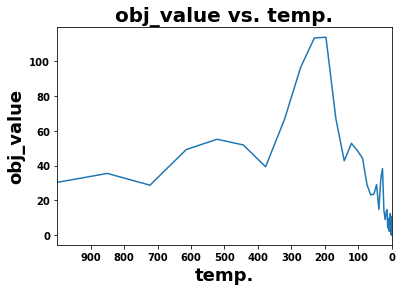

In [76]:
for i in range(parameters['num_inputs']):
    print('x' + str(i+1) + ' is %.5f' % solution[0,i])
print("Final OF is %.5f" % obj_value)


plt.plot(temp_list, obj_value_list)
plt.title("obj_value vs. temp.",fontsize=20, fontweight='bold')
plt.xlabel("temp.",fontsize=18, fontweight='bold')
plt.ylabel("obj_value",fontsize=18, fontweight='bold')

plt.xlim(1000,0)
plt.xticks(np.arange(min(temp_list),max(temp_list),100),fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()


# Combinatorial Simulated Annealing

In [2]:
parameters_combinatorial = {
                              'initial_temperature' : 1500
                            , 'cooling_iterations' : 250
                            , 'cooling_parameter' : 0.9
                            , 'neighbourhood_searches' : 20
                            , 'flow_matrix' : np.array([[0,5,2,4,1,0,0,6]
                                                       ,[5,0,3,0,2,2,2,0]
                                                       ,[2,3,0,0,0,0,0,5]
                                                       ,[4,0,0,0,5,2,2,10]
                                                       ,[1,2,0,5,0,10,0,0]
                                                       ,[0,2,0,2,10,0,5,1]
                                                       ,[0,2,0,2,0,5,0,10]
                                                       ,[6,0,5,10,0,1,10,0]])
                            , 'distance_matrix' : np.array([[0,1,2,3,1,2,3,4]
                                                           ,[1,0,1,2,2,1,2,3]
                                                           ,[2,1,0,1,3,2,1,2]
                                                           ,[3,2,1,0,4,3,2,1]
                                                           ,[1,2,3,4,0,1,2,3]
                                                           ,[2,1,2,3,1,0,1,2]
                                                           ,[3,2,1,2,2,1,0,1]
                                                           ,[4,3,2,1,3,2,1,0]])
                            , 'initial_configuration' : np.array([1,3,0,4,2,5,6,7])
                            , 'num_inputs' : 8
                              }

In [3]:
def peturb_inputs_combinatorial(inputs):
    
    """
    This function switches two values in the input array at random.
    """
    
    num_inputs = len(inputs)
    
    # get two distinct random numbers in range of our index array
    rand1 = np.random.randint(0,num_inputs)
    rand2 = np.random.randint(0,num_inputs)
    while rand1 == rand2:
        rand2 = np.random.randint(0,num_inputs)
    
    # get the indexes of these inputs
    index1 = np.where(inputs==rand1)[0][0]
    index2 = np.where(inputs==rand2)[0][0]
    
    # copy the array
    outputs = np.copy(inputs)
    
    # switch the values
    outputs[index1] = rand2
    outputs[index2] = rand1
    
    return outputs

In [4]:
def shuffle_matrix(input_matrix, shuffle_array):
    
    """
    This function shuffles a square 2d array (matrix) along both axis
    , using the indexes in the shuffle array.
    """
    
    if input_matrix.shape[0] != input_matrix.shape[1]:
        raise Exception('Input matrix must be square.')
    if input_matrix.shape[0] != shuffle_array.shape[0]:
        raise Exception('Shuffle array must match input matrix dimension.')
    
    # copy the matrix
    output_matrix = np.copy(input_matrix)
        
    return output_matrix[:,shuffle_array][shuffle_array,:]

In [5]:
def get_total_cost(distance_matrix, flow_matrix):
    
    """
    Get the total cost of flow by multiplying the distance and 
     flow matricies and summing the resulting matrix.
    """
    
    return np.sum(distance_matrix * flow_matrix)

In [6]:
def simulated_annealing_combinatorial(parameters, objective_function):
    
    # unpack parameters
    initial_temperature = parameters['initial_temperature']
    cooling_iterations = parameters['cooling_iterations']
    cooling_parameter = parameters['cooling_parameter']
    neighbourhood_searches = parameters['neighbourhood_searches']
    flow_matrix = parameters['flow_matrix']
    distance_matrix = parameters['distance_matrix']
    initial_configuration = parameters['initial_configuration']
    num_inputs = parameters['num_inputs']

    # initialise lists to record temperatures and the min 
    # objective function value at each temperature
    temperatures = []
    min_obj_func = []
    
    # put in our inital values
    configuration_t = initial_configuration
    distance_matrix_t = shuffle_matrix(distance_matrix, configuration_t)
    temperature = initial_temperature

    # run through all the cooling iterations
    for i in range(cooling_iterations):
        
        # run through a set number of neighbourhood searches
        for j in range(neighbourhood_searches):

            # perturb configuration_t to get configurations at t+1
            configuration_t_plus_1 = peturb_inputs_combinatorial(configuration_t)
            
            # calculate distances for peturbed configurations
            distance_matrix_t_plus_1 = shuffle_matrix(distance_matrix, configuration_t_plus_1)

            # calculate objective funtion of both old and new
            obj_func_new = objective_function(distance_matrix_t_plus_1, flow_matrix)
            obj_func_current = objective_function(distance_matrix_t, flow_matrix)

            # calculate our acceptance probability for moving to a worse solution
            accept_prob = np.exp(-(obj_func_new-obj_func_current)/temperature)

            # if the new solution is better take that
            # failing that accept it anyway with chance accept_prob
            if obj_func_new <= obj_func_current or np.random.rand() <= accept_prob:
                configuration_t = configuration_t_plus_1
                distance_matrix_t = distance_matrix_t_plus_1

        # keep track of temperatures and minumum objective values
        temperatures = np.append(temperatures, temperature)
        min_obj_func = np.append(min_obj_func, obj_func_current)
        
        # anneal the temperature down
        temperature = cooling_parameter * temperature
        
    return configuration_t, obj_func_current, temperatures, min_obj_func

In [7]:
solution , obj_value, temp_list , obj_value_list = simulated_annealing_combinatorial(parameters_combinatorial, get_total_cost)

solution is [6 7 3 5 4 0 1 2]
Final OF is 214


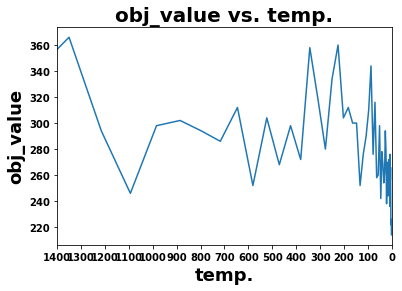

In [9]:
print('solution is ' + str(solution))
print('Final OF is ' + str(obj_value))


plt.plot(temp_list, obj_value_list)
plt.title("obj_value vs. temp.",fontsize=20, fontweight='bold')
plt.xlabel("temp.",fontsize=18, fontweight='bold')
plt.ylabel("obj_value",fontsize=18, fontweight='bold')

plt.xlim(1000,0)
plt.xticks(np.arange(min(temp_list),max(temp_list),100),fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()

In [12]:
start_time = tt.default_timer()
outs = []
for i in range(100):
    solution , obj_value, _, _  = simulated_annealing_combinatorial(parameters_combinatorial, get_total_cost)
    outs.append(obj_value)
print(tt.default_timer() - start_time)

21.90330382282463


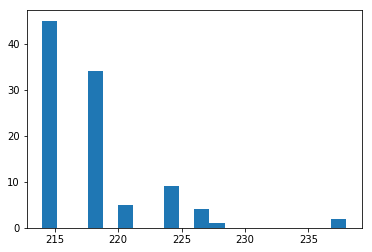

In [13]:
plt.hist(outs,bins=20)
plt.show()